# Train MPOX detection models

Based on the paper *H-MpoxNet: A Hybrid Deep Learning Framework for Mpox Detection from Image Data* by S. Chakroborty et al., 2024

Will fine tune a CNN model:
- Dataset: [MSLD-v1](https://github.com/mHealthBuet/Monkeypox-Skin-Lesion-Dataset)
    - Binary: Monkeypox, Others (chickenpox and measles)
    - 224 x 224 x 3
	- 228 original images (102 'Monkeypox'; 126 'Others'). 
	- augmented to 3,192 images (1,428 'Monkeypox'; 1764 in 'Others').
- Pretrained model: Densenet 201, Densenet 169, MobileNetV2 trained with Imagenet-1k
- Hyperparameters: none from this paper.
	- BS: [16 32 64]
	- LR:  [0.01 0.001]
    - nbr epochs: 200

In [19]:
from eccore.ipython import nb_setup
nb_setup()

import matplotlib.pyplot as plt
import re
import torch
import umap

from pprint import pprint
from uuid import uuid4
from IPython.display import Markdown, display


from fastai import __version__ as fastai_version
from fastai.vision.all import *
from fastai.callback.all import ShowGraphCallback
from pathlib import Path
from utils import run_experiment, create_image_features, plot_features, parse_saved_fnames, ROOT, DATASETS
from utils import validate_models, plot_training_and_validation_metrics, model_weight_files

print(f"Using fastai version {fastai_version}")
saved = ROOT / "saved"
data = ROOT / "data"

train_ds = "msld-v1"
p2train_ds = DATASETS[train_ds]['path']
assert p2train_ds.is_dir(), f"Training dataset path {p2train_ds} is not a directory."
print(f"This notebook will use {train_ds} training dataset ({p2train_ds})")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# styles = plt.style.available
plt.style.use('default')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Set autoreload mode
Using fastai version 2.8.3
This notebook will use msld-v1 training dataset (/home/vtec/projects/bio/mpox-prestudy/data/MSLD-v1/Augmented)
Using device: cuda


In [15]:
imgs_train_ds = get_image_files(p2train_ds)
imgs_mpox = get_image_files(p2train_ds / "Monkeypox")
imgs_others = get_image_files(p2train_ds / "Others")
print(f"Training dataset ({train_ds}): {len(imgs_train_ds):,} images found in {p2train_ds}")
print(f" - Monkeypox: {len(imgs_mpox):,} images")
print(f" - Others:    {len(imgs_others):,} images")

Training dataset (msld-v1): 3,192 images found in /home/vtec/projects/bio/mpox-prestudy/data/MSLD-v1/Augmented
 - Monkeypox: 1,428 images
 - Others:    1,764 images


Quick review of the training dataset

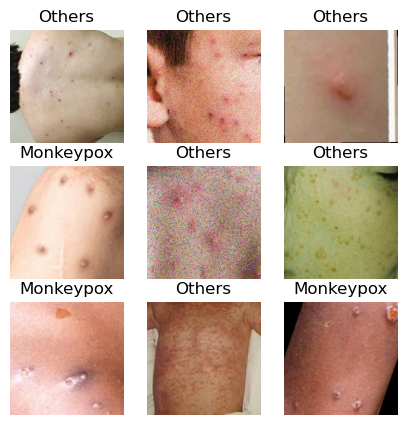

In [20]:
dls = ImageDataLoaders.from_folder(
    path=p2train_ds,
    valid_pct=0.2,
    item_tfms=Resize(224),
    bs=32
)
dls.show_batch(max_n=9, show=True, figsize=(5,5))

In [22]:
# learn = run_experiment(resnet18, train_ds='msld-v1', freeze_epochs=1, n_epoch=1, lr=1e-3, bs=32, suggested_lr='minimum', save_records=False)

## Explore hyperparameters

### Finetuning

Running experiment 1/2: bs=64; lr=None
> Finding learning rate...


  lrs.minimum: 2.75e-03 
  lrs.steep  : 9.12e-07  
  lrs.valley : 8.32e-04


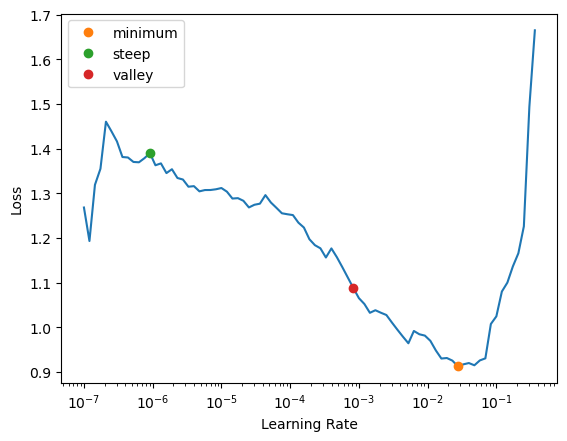

  Using valley learning rate: 8.32e-04

densenet169_2_64_8.3e-04_msld-v1
> Fine-tuning densenet169 on msld-v1 for 2 epochs with batch size 64 ...


epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.626787,0.266818,0.861878,0.923077,0.880878,0.891429,00:17


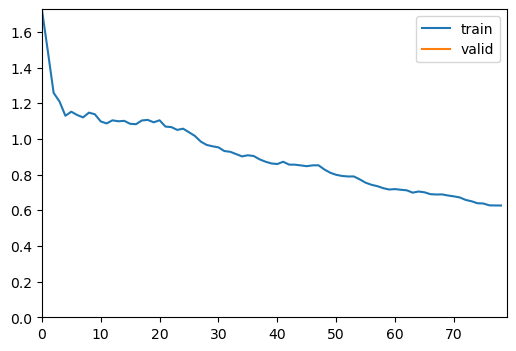

epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.285760,0.162184,0.972376,0.936170,0.946708,0.953930,00:25
1,0.143700,0.084272,0.966851,0.972222,0.965517,0.969529,00:23


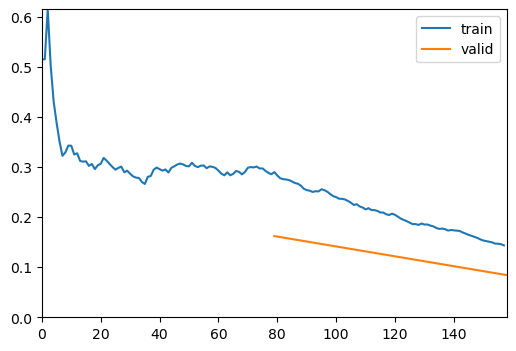

> Training records not saved
----------------------------------------

Running experiment 2/2: bs=32; lr=None
> Finding learning rate...


  lrs.minimum: 3.31e-03 
  lrs.steep  : 1.91e-06  
  lrs.valley : 1.20e-03


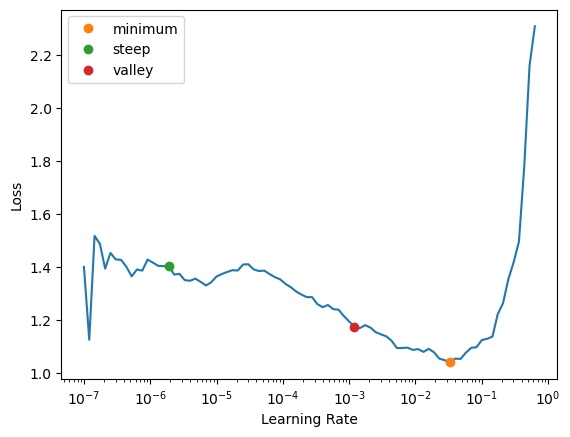

  Using valley learning rate: 1.20e-03

densenet169_2_32_1.2e-03_msld-v1
> Fine-tuning densenet169 on msld-v1 for 2 epochs with batch size 32 ...


epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.612531,0.253186,0.921283,0.905444,0.905956,0.913295,00:19


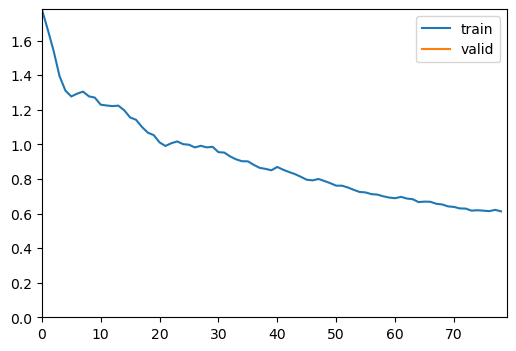

epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.268433,0.179512,0.918367,0.943114,0.926332,0.930576,00:28
1,0.149410,0.125906,0.979592,0.930748,0.949843,0.954545,00:27


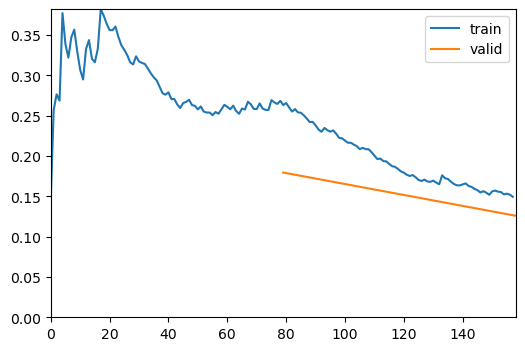

> Training records not saved
----------------------------------------



In [24]:
freeze_epochs = 1
n_epoch = 2
SAVE_RECORDS = True
SAVE_RECORDS  = False

hyperparams = (
    # (None, 32),
    # (None,16),
    (None,64),
    (None,32)
)

for i, (lr, bs) in enumerate(hyperparams):
    print(f"Running experiment {i+1}/{len(hyperparams)}: bs={bs}; lr={lr}")
    learn = run_experiment(
        densenet169,
        train_ds='msld-v1',
        freeze_epochs=freeze_epochs, 
        n_epoch=n_epoch, 
        lr=lr, 
        bs=bs, 
        save_records=SAVE_RECORDS)
    print(f"{'-'*40}\n")

### Validation

In [ ]:
dls_test = ImageDataLoaders.from_folder(data / 'MSID-binary', valid_pct=0.90, item_tfms=Resize(224))

In [ ]:
saved_models = [p for p in saved.glob('*.pth')]
[p.stem for p in saved_models]

In [ ]:
learn = vision_learner(
    dls_test,
    resnet18,
    loss_func=CrossEntropyLossFlat(),
    metrics=[Recall(), Precision(), accuracy, F1Score()]
)

validation_results = {}
for m in saved_models:
    print(f"Validating data with model {m.stem}")
    load_model(file=saved_models[0], model=learn.model,opt=learn.opt, with_opt=False)
    res = learn.validate()
    validation_results[m.stem] = res
    pprint(validation_results)
    

In [ ]:
import pandas as pd
results_df = pd.DataFrame(validation_results, ).T
results_df.columns = ['val_loss']+[m.name for m in learn.recorder.metrics]
results_df

In [ ]:
# val_images = get_image_files(data/'MSID-binary')
# print(len(val_images))
# test_dl = learn.dls.test_dl(val_images, bs=64, after_item=[Resize(224)], shuffle=False)